# Exercise 13: A nonlinear version of `mBasicInt`

In this exercise you will get familiar with non-linear energy system models. It is required that you have read the lecture note on non-linear energy system models.

We will be working with a nonlinear version of the rather simple `mBasicInt` model. For simple versions, we can use `SCIPY`'s algortithms for solving non-linear models, but for large models we will have to build our own algorithms for solving and estimating the model.

# 0. Import packages

We start by just importing standard packages:

In [1]:
%run ../stdPackages.ipynb

Then we need some functions for reading in the model databases:

In [2]:
from pyDbs import read, readSets, broadcast

`mBasicInt_NonLinear` is the class you will be working for in this exercise. You will also be using the standard LP framework in the `mBasicInt` class.  

In [3]:
from Solution.mBasicInt_NonLinearv2_final import *
os.chdir(d['py'])
from mBasicInt import *
os.chdir(d['curr'])

We will use the following for estimating the time spent solving the model:

# 1. Read data

We will be using two different model databases. One of them only contains a few hours. This is usefull when building, simulating and estimating new models. The large model database contains all 8760 hours. With this size of model you will get to see the hoops and loops that will enable to solve and even estimate such a large model. 

This dictionary specifies the structure of the excel files:

In [4]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['Scalars'],
        'maps': ['Generators_Categories']}

We first read in the small database, and call it `db_s` for db_small:

In [5]:
# path_to_small_dataset = os.path.join(d['curr'],'Solution','mBasicInt_NonLinear_final.xlsx')
path_to_small_dataset = os.path.join(d['curr'],'Data','mBasicInt_NonLinear.xlsx')
db_s = read.dbFromWB(path_to_small_dataset, kwargs)
db_s.updateAlias(alias=[('h','h_alias')])
readSets(db_s)

Next, we read in the large database, and call it `db_l` for db_large:

In [6]:
path_to_large_dataset = os.path.join(d['curr'],'Data','mBasicIntLarge_NonLinear.xlsx')
db_l = read.dbFromWB(path_to_large_dataset, kwargs)
db_l.updateAlias(alias=[('h','h_alias')])
readSets(db_l)

In [7]:
# db_4 = db_l.copy()
# [db_4.__setitim([

SyntaxError: unexpected EOF while parsing (3960591231.py, line 2)

# 2. Class initialization

Before building the non-linear model, let's have a look at the initialization of the class, `mSimpleNL`.

The model initialization then consists of the following code-chunk:
```python
class mSimpleNL(): 
    def __init__(self, db):
        mSimpleNL.updateDB(db) # <-- The model database is updated by adding a smoothing parameter (sigma) and a price vector. 
        self.db = db # <-- Assigns the model database to the class.
        self.endo_vars = {'x_vars':['p'],'theta_vars':[]} # <-- See Comment A)
        self.idx_endo = {'p': range(0,len(self.db['h']))} # <-- See Comment B)		
        self.set_model_structure() # <-- This function sets class properties relating to the dimensions of the model.
        self.set_model_parameters()	# <-- This function sets model parameters (i.e. exogenous parameters)
```
Somme addition comments are warrented:

**Comment A):** The keys of this dictionary are the endogenous variables (denoted _x_vars_) and the endogenous parameters in a structural estimation (denoted _theta_vars_). The values are a list of variable names. For now, we will abstract from any estimation and therefore _theta_vars_ is just an empty list. This dictionary is really helpful, when the vector of endogenous variables consists of multiple variables. 

**Comment B):** _idx_endo_ specifies the index numbers of the endogenous numpy array. For instance. The endogenous price vector is indexed by the first $0:8759$. 

# 3. Model simulations

Before going into specific, let's have a look at the following function in the `mSimpleNL`-class:

```python
def xArray2pdSeries(self,x,variable='p'):
	""" Method for transforming endogenous variables from a numpy array to an indexed Pandas Series """
 	return pd.Series(x[self.idx_endo[variable]],index=self.db[variable].index,name=variable) if variable in self.idx_endo.keys() else self.db[variable]
```

Rather than being structured via numpy arrays, the model is structured via pandas series. This is obviously less efficient than working with numpy arrays, but when working with (potentially) high-dimensional models the multindex-feature of pandas series greatly simplifies setting of the model. Especially, when defining such models for the first time. The _xArray2pdSeries_-function simply converts the endogenous vector (in numpy array) to a pandas series with the correct index. 

## 3.1 Simple small model

In the following, you will be working with the small model database with a relatively few hours. 

In [8]:
m = mSimpleNL(db_s)

Similarly, to test the model, we need a guess of the equilibrium price vector $\mathbf{p}^*=(p_1^*,\ldots,p_H^*)'$. We are going to denote it $p^0$ just assume it is given by

\begin{equation*}
    \frac{1}{N}\sum_{i=1}^{N} c^{\text{other}}_i+\sum_j \mu_{i,j}p_j
\end{equation*}

In [9]:
p0 = np.repeat(m.averageMC.mean(),m.H)

### Question 3.1A

Make a smooth supply function. You should add the following function and fill in the rest in the `mSimpleNL`-class:
```python
def Supply(self,x):
	""" Smooth supply function """
	Inner = pd.Series(0,index=self.id2h).add(self.xArray2pdSeries(x,variable='p')).sub(self.averageMC).div(self.xArray2pdSeries(x,variable='p'))
	return ... # <-- fill in here.
```
*Note: The function should return the smoothed supply function $\mathbf{S}(\mathbf{p})$, which for a given hour is given by*


\begin{equation*}
    S_h(p_h) = \sum_i q_i\Phi\left(\frac{p_h-mc_i}{\sigma}\right)
\end{equation*}

*Finally, note that the variable "Inner" in the "Supply"-function above is* $\frac{\mathbf{p}-\mathbf{mc}}{\sigma}$.

To ensure the function works, try computing $S(p^0)$. It should look something like this:

| h | Supply |
|:--------:|:--------:|
|  1   |  88.05   |
|  2   |  70.60   |
|  3   |  61.88   |
| 4 | 81.07 |

In [10]:
m.Supply(p0) # ... Check here

h
1    88.053047
2    70.602244
3    61.876843
4    81.072726
dtype: float64

### Question 3.1B

Add an excess demand function to `mSimpleNL`. You should copy and fill the rest:
```python
def ExcessDemand(self,x):
	""" Equilibrium indentity defined as excess demand"""
	return ... # <-- fill in here.
```
*Note: The function should return,*
\begin{equation}
\mathbf{ED}(\mathbf{p}) = \mathbf{D}-\mathbf{S}(\mathbf{p})
\end{equation}
*where demand is exogenous (i.e. price inelastic) and defined as a property of `mBasicInt_Nonlinear`.*

Finally, try computing $\mathbf{ED}(\mathbf{p}^0)$ to ensure the function works. It should something like this:

| h | Excess Demand |
|:--------:|:--------:|
|  1   |  -48.05   |
|  2   |  49.40   |
|  3   |  138.12   |
| 4 | -41.07 |

In [11]:
m.ExcessDemand(p0) # ... Check here

h
1    -48.053047
2     49.397756
3    138.123157
4    -41.072726
dtype: float64

### Question 3.1C

In this question, you are comment of two graphs. The first is the supply and demand curve for each hour. The second if the excess demand function in each hour. 

We will start out by making a price grid to draw the function of this grid:

In [12]:
grid_size = 100
p_min, p_max = 0, 40
p_grid = np.linspace(p_min,p_max,grid_size).repeat(m.H).reshape(grid_size,m.H) 

Now we will compute the supply:

In [13]:
S = pd.Series(
    np.array([m.Supply(x).values for x in p_grid]).flatten(),
    index=pd.MultiIndex.from_product([p_grid.mean(axis=1),m.db['h'].tolist()],names=['p','h']),
    name=r'Supply'
)
D = S*0+m.Demand

Next we plot supply and demand curves:

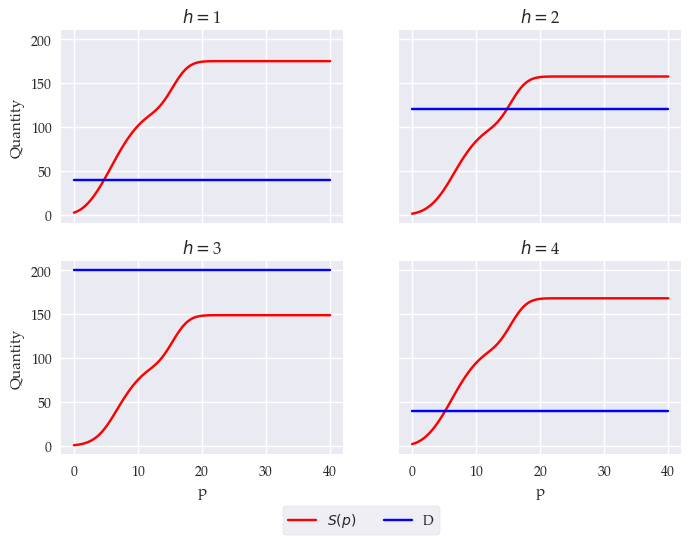

In [14]:
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True)
titles = [r'$h=$'+str(x) for x in m.db['h']]
S.unstack('h').plot(subplots=True,ax=ax,color='red',title=titles,xlabel=r'$p$',ylabel='Quantity',legend=False)
D.unstack('h').plot(subplots=True,ax=ax,color='blue',legend=False)
fig.legend([r'$S(p)$','D'],loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=True)

Now we plot the excess demand functions:

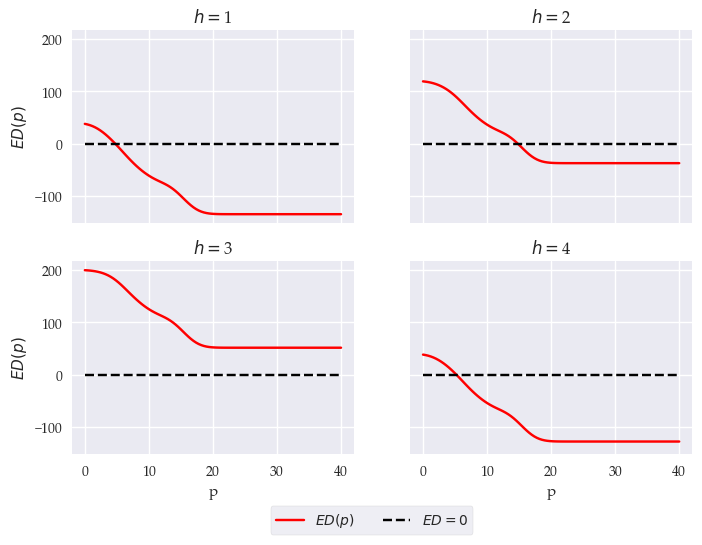

In [15]:
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True)
titles = [r'$h=$'+str(x) for x in m.db['h']]
(D-S).unstack('h').plot(subplots=True,ax=ax,color='red',title=titles,xlabel=r'$p$',ylabel=r'$ED(p)$',label='ED',legend=False)
(D*0).unstack('h').plot(subplots=True,ax=ax,color='black',linestyle='--',legend=False)
fig.legend([r'$ED(p)$',r'$ED=0$'],loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=True)

**Answer:**

In all hours except $h=3$ do we have a unique equilibrium. In $h=3$ there is too little generating capacity to establish an equilbrium, given that demand is always larger than supply (i.e. the excess demand curve is always positive). 

### Question 3.1D

Why is the equilibrium price in the standard `mBasicInt` in hour $3$ given by $\lambda_3=25$?

In [20]:
%%capture
m_LP = mSimple(db_s)
m_LP();

In [16]:
x0 = m_LP.db['marginalSystemCosts'].values
x0[2]

25.0

**Answer:**

This is due to load shedding. There is not enough capacity and therefore the load is shedded in $h=3$ at the marginal willingness to pay (MWP) at $\text{MWP}=25$.

### Question 3.1E

Given your answers above, explain the equilibrium condition in `mBasicInt_Nonlinear`, which is defined in the following function:

```python
def EquilibriumExists(self):
		""" Equilibrium condition checking whether an equilbrium exists"""
		MissingCapacity = self.Demand - self.hourlyGeneratingCapacity.groupby('h').sum()
		if (MissingCapacity>0).any():
		 	warnings.warn(r'You are missing '+str(MissingCapacity.round(1).max())+' in generating capacity for an equilibrium to exist in hour h='+str(MissingCapacity.idxmax()), UserErrorMessage)
		else:
		 	return True
```

*Note: You can gain intuition by checking the function:*

In [17]:
m.EquilibriumExists()

C:\Users\xnh825\Documents\GitHub\EnergyEconomicsE2023\Exercises\E45\Solution\mBasicInt_NonLinearv2_final.py:169: UserErrorMessage: You are missing 51.2 in generating capacity for an equilibrium to exist in hour h=3
  warnings.warn(r'You are missing '+str(MissingCapacity.round(1).max())+' in generating capacity for an equilibrium to exist in hour h='+str(MissingCapacity.idxmax()), UserErrorMessage)


**Answer:**

For a given hour $h$, the condition reads $D_h - \sum_i q_{i,h}>0$. If this condition is fulfilled, demand will always be larger than aggregate supply. This is because $\Phi\left(\frac{p_h-mc_i}{\sigma}\right) \leq 1 $. 

### Question 3.1F

To ensure, we can always find an $ED(p^*)=0$, we will simply add a fictional plant called and Energy Deficiency Plant with the id=EDP. However, it is important to note, that this plant is a measure of load-sheddig and not generation. 

Add the specified number of generating capacity in the excel file for the model database by adding _standard_ plant with the id=EDP - short for Energy Deficiency Plant - with the following characteristics:
- $mc^{\text{other}}_{\text{EDP}}=25$
- $q_{\text{EDP}} = 60 $
- $\forall j: \mu_{\text{EDP},j} = 0$

You should be able to import the data using the following chunk:

In [18]:
path_to_small_dataset = os.path.join(d['curr'],'Solution','mBasicInt_NonLinear_final.xlsx')
db_s = read.dbFromWB(path_to_small_dataset, kwargs)
db_s.updateAlias(alias=[('h','h_alias')])
readSets(db_s)

### Question 3.1G

You will soon be asked to compute the equilibrium price vector. To do this, we will start by doing this by writing a wrapper around `SCIPY`'s [fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)-function. The fsolve function just compute the solution to a sqaure system of nonlinear equations. 

You should add the following function to `mBasicInt` and fill in the "func"-argument in the _fsolve_-function:

```python
def ScipySolver(self,x0=None,full_output=False):
	""" A wrapper around Scipy's fsolve function"""
    if self.EquilibriumExists():
        if x0 is None:
            x0 = self.db['p'].values # <-- If the user does not provide an initial quess for p*, we will manually assign one.
        return fsolve(func=lambda x:..., x0=x0,full_output=full_output) # <-- fill in the dots
```
*Note: The function your are asked to provide is the equilibrium identity. The easiest approach is to provide a lambda-expression).*

You can check the function by running: 

In [28]:
m = mSimpleNL(db_s)
p_star = m.ScipySolver(x0=p0)
p_star

array([ 4.72195156, 14.77741799, 27.10894493,  5.18703057])

### Question 3.1H:

In [24]:
m.ExcessDemand(sol[0]).round(1)

h
1   -0.0
2   -0.0
3   -0.0
4    0.0
dtype: float64

Get inital guess from LP model:

In [15]:
m_LP = mSimple(db_s)
m_LP()
x0 = m_LP.db['marginalSystemCosts'].values
display(pd.Series(x0,index=m.db['h']))

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


h
1     6.189324
2    15.402685
3    25.000000
4     6.189324
dtype: float64

In [13]:
from scipy.optimize import fsolve, minimize
fsolve(lambda x: m.ExcessDemand(x), x0=x0)

array([ 4.72195155, 14.77741799, 27.10894492,  5.18703058])

In [12]:
fsolve(lambda x: m.ExcessDemand(x), x0=m.db['p'])

C:\Users\xnh825\Anaconda3\envs\EEotGT23\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([  4.72195155,  14.77741798, 221.72439599,   5.18703058])

In [ ]:
def avg_supply(price_matrix,model):
    q = model.hourlyGeneratingCapacity.groupby('id').mean()
    S =[model.simple_CapacityUtilization(x).mul(q).groupby('h').sum().mean() for x in price_matrix]
    return pd.Series(S,index=pd.Index(price_matrix.mean(axis=1),name='Price'),name='Supply')

In [14]:
x0

array([ 6.18932398, 15.40268456, 25.        ,  6.18932398])